# Random Forest and Features Importance

## Abstract

Questo Notebook vuole dimostrare come usare la funzione _Features Imporance_ dell'algoritmo _Random Forest_ di **sklearn**.
Al fine di poter dimostrare tutto ciò, prenderemo come variabile dipendente (**y**) il valore dell'indice americano **S&P's 500** e come set di variabili indipendenti (**X**) una serie di indicatori calcolati o redistribuiti dalla Federal Reserve di St. Louis, MO - https://www.stlouisfed.org/

Tutti i dati usati in questo Notebook sono stati scaricati tramite Quandl - https://www.quandl.com/

**P.S. Al fine di poter scaricare i vostri dati, dovete inserire la vostra API key!**

In [1]:
import pandas as pd
import quandl
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [2]:
quandl.ApiConfig.api_key = 'inserisci la tua API key qui'
series = [
    "FRED/GDPC1",
    "FRED/UNEMPLOY",
    "FRED/ICSA",
    "FRED/PAYEMS",
    "FRED/INDPRO",
    "FRED/DFF",
    "FRED/DGS10",
    "FRED/BOPTEXP",
    "FRED/BASE",
    "FRED/CPIAUCSL",
    "FRED/PCE",
    "FRED/PSAVERT",
    "FRED/HOUST",
    "FRED/DTWEXM",
    "FRED/GFDEBTN",
    "CHRIS/CME_QM1.6",
    "CHRIS/ICE_DX1.6",
    "CHRIS/CME_GC1.6"
]

Rinominiamo i codici dei datasets in Quandl con la loro descrizione

In [3]:
column_names = {
    "FRED/GDPC1": "Real Gross Domestic Product",
    "FRED/UNEMPLOY": "Unemployment",
    "FRED/ICSA": "Initial Claims",
    "FRED/PAYEMS": "All Employees: Total nonfarm",
    "FRED/INDPRO": "Industrial Production Index",
    "FRED/DFF": "Effective Federal Funds Rate",
    "FRED/DGS10": "10-Year Treasury Constant Maturity Rate",
    "FRED/BOPTEXP": "Exports of Goods and Services, Balance of Payments Basis",
    "FRED/BASE": "St. Louis Adjusted Monetary Base",
    "FRED/CPIAUCSL": "Consumer Price Index for All Urban Consumers: All Items",
    "FRED/PCE": "Personal Consumption Expenditures",
    "FRED/PSAVERT": "Personal Saving Rate",
    "FRED/HOUST": "Housing Starts: Total: New Privately Owned Housing Units Started",
    "FRED/DTWEXM": "Trade Weighted U.S. Dollar Index: Major Currencies",
    "FRED/GFDEBTN": "Federal Debt: Total Public Debt",
    "CHRIS/CME_QM1.6": "E-mini Crude Oil Futures - Settle",
    "CHRIS/ICE_DX1.6": "US Dollar Index Futures - Settle",
    "CHRIS/CME_GC1.6": "Gold Futures - Settle"
}

Una volta preparati i metadati, possiamo eseguire il modulo per scaricare i dati da Quandl:
1. La data di inizio delle serie numerica è stata fissata al 1 Gennaio 2000
2. La cadenza di queste timeseries è stata determinata come **mensile**, ovvero indipendentemente dalla cadenza temporale con cui vengono aggiornati i dati, ho deciso di selezionare solo i dati di ogni fine mese tramite il parametro _collapse_
3. Per quanto riguarda la serie dello S&P's 500, **CHRIS/CME_SP1.6**, il _.6_ sta a significare che voglio scaricare solo la sesta colonna del dataset, in questo caso _Settle_

In [4]:
X = quandl.get(series, start_date="2000-01-01", collapse="monthly")
y = quandl.get("CHRIS/CME_SP1.6", start_date="2000-01-01", collapse="monthly")

Siccome le serie presentano dei dati mancanti oppure hanno semplicemente delle differenze in termini di frequenza di aggiornamento, tramite il comando _fillna_ ed i due diversi metodi, farò:
- Prima il _Forward Fill_ dei dati, ovvero una estrapolazione (riempio i valori mancanti dal giorno 1 al giorno 5 copiando i valori dal giorno 1)
- Successivamente farò un _Back Fill_, ovvero copierò i dati mancanti all'inizio delle timeseries con il primo dato disponibile

In questo modo non avremo più dati mancanti

In [5]:
X.fillna(method="ffill", inplace=True)
X.fillna(method="bfill", inplace=True)
y.fillna(method="ffill", inplace=True)

Sostituisco la leggenda delle colonne con la loro descrizione invece che il loro codice nel database di Quandl

In [6]:
X.columns = list(column_names.values())

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.25)

Stimo il _RandomForestRegressor_ usano 10,000 stimatori (_trees_)

In [8]:
rf = RandomForestRegressor(n_estimators=10000)
rf.fit(X_train, y_train)

<ipython-input-8-a29afa7819f9>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10000)

In [9]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.998
RF test accuracy: 0.989


Calcoliamo l'importanza delle variabili (o _features_) usando l'algoritmo _Permutation Importance_ (per maggiori informazioni sul problema di _impurity-mean_ potete trovare più informazioni [qui](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

In [10]:
perm_importance = permutation_importance(rf, X_test, y_test)

<BarContainer object of 18 artists>

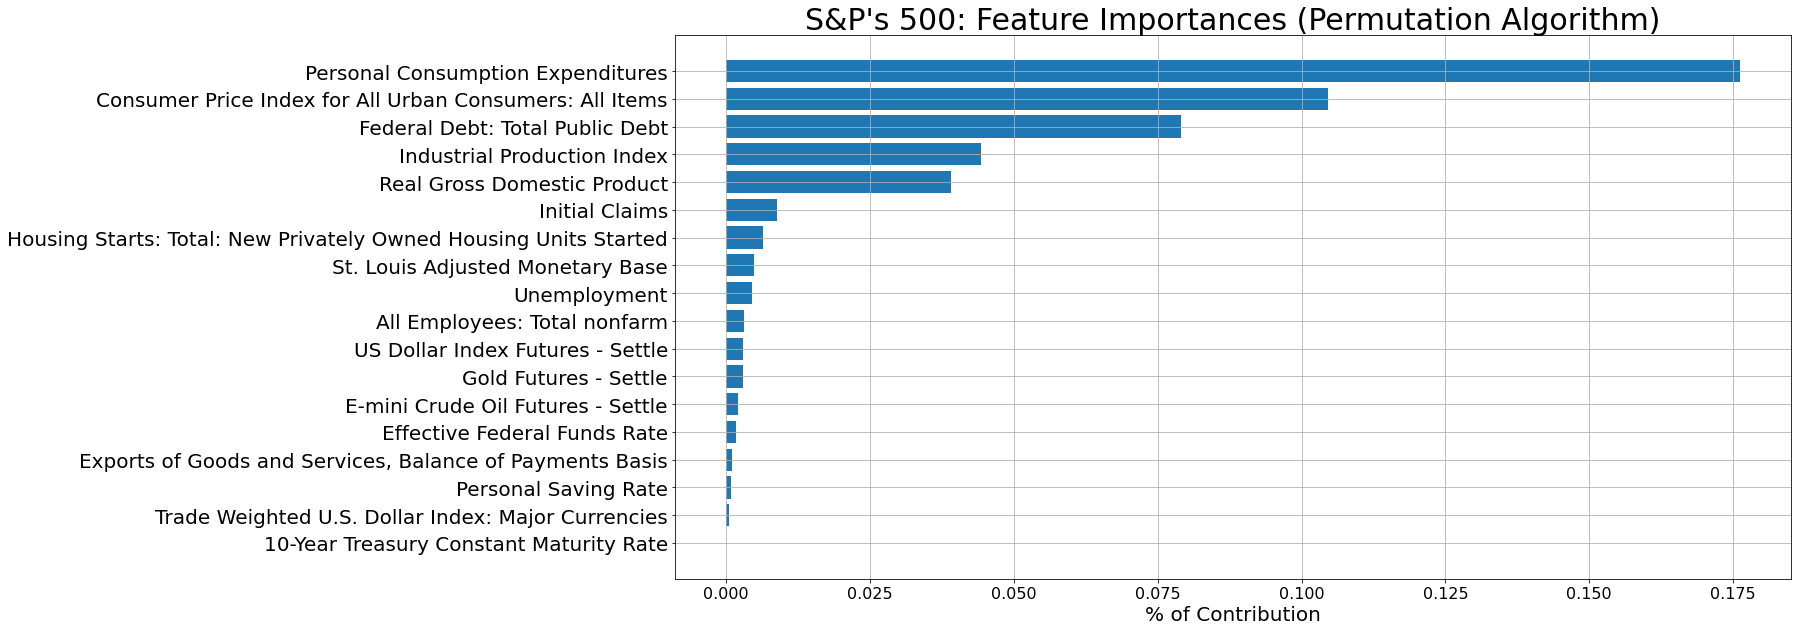

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xlabel('% of Contribution', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
ax.grid()
sorted_idx = perm_importance.importances_mean.argsort()
plt.title("S&P's 500: Feature Importances (Permutation Algorithm)", fontsize=30)
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])

Una volta calcolate le differenze ed evidenziate nel bar chart sopra, possiamo brevemente concludere che, fra le variabili utilizzate nella nostra analisi:
- La spesa procapite delle famiglie, l'inflazione, il debito pubblico, l'inidce della produzione industriale ed infine il GDP sono indicatori che spiegano quasi il 40% dell'andamento dello S&P's 500 negli ultimi 21 anni.
- Fattori come la disoccupazione, il tasso di cambio e le esportazioni non sembrano avere degli effetti predittivi nel lasso di tempo considerato
- Il prezzo del petrolio, nel lasso di tempo considerato, sembra essere la variabile meno predittiva di tutte

## Un esempio di Albero Decisionale

Come ultima curiosità, volevo mostrarvi quanto complesso potesse essere un solo albero decisionale (pensate che in questo semplicissimo modello ne abbiamo stimato 10,000!).
L'algoritmo sceglie in base al coefficiente di _impurità_ di Gini:

$1-(p_{true})^2-(p_{false})^2$

Dove $p_{true}$ rappresenta la percentuale di casi positivi per ogni nodo mentre $p_{false}$, al contrario, rappresenta la percentuale di casi negativi per ogni nodo. La _feature_ che minimizzerà questo coefficiente sarà scelta come predittiva per quel singolo nodo.

Per ulteriori informazioni, consultate questi due utilissimi video:

In [33]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/7VeUPuFGJHk" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [32]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/J4Wdy0Wc_xQ" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

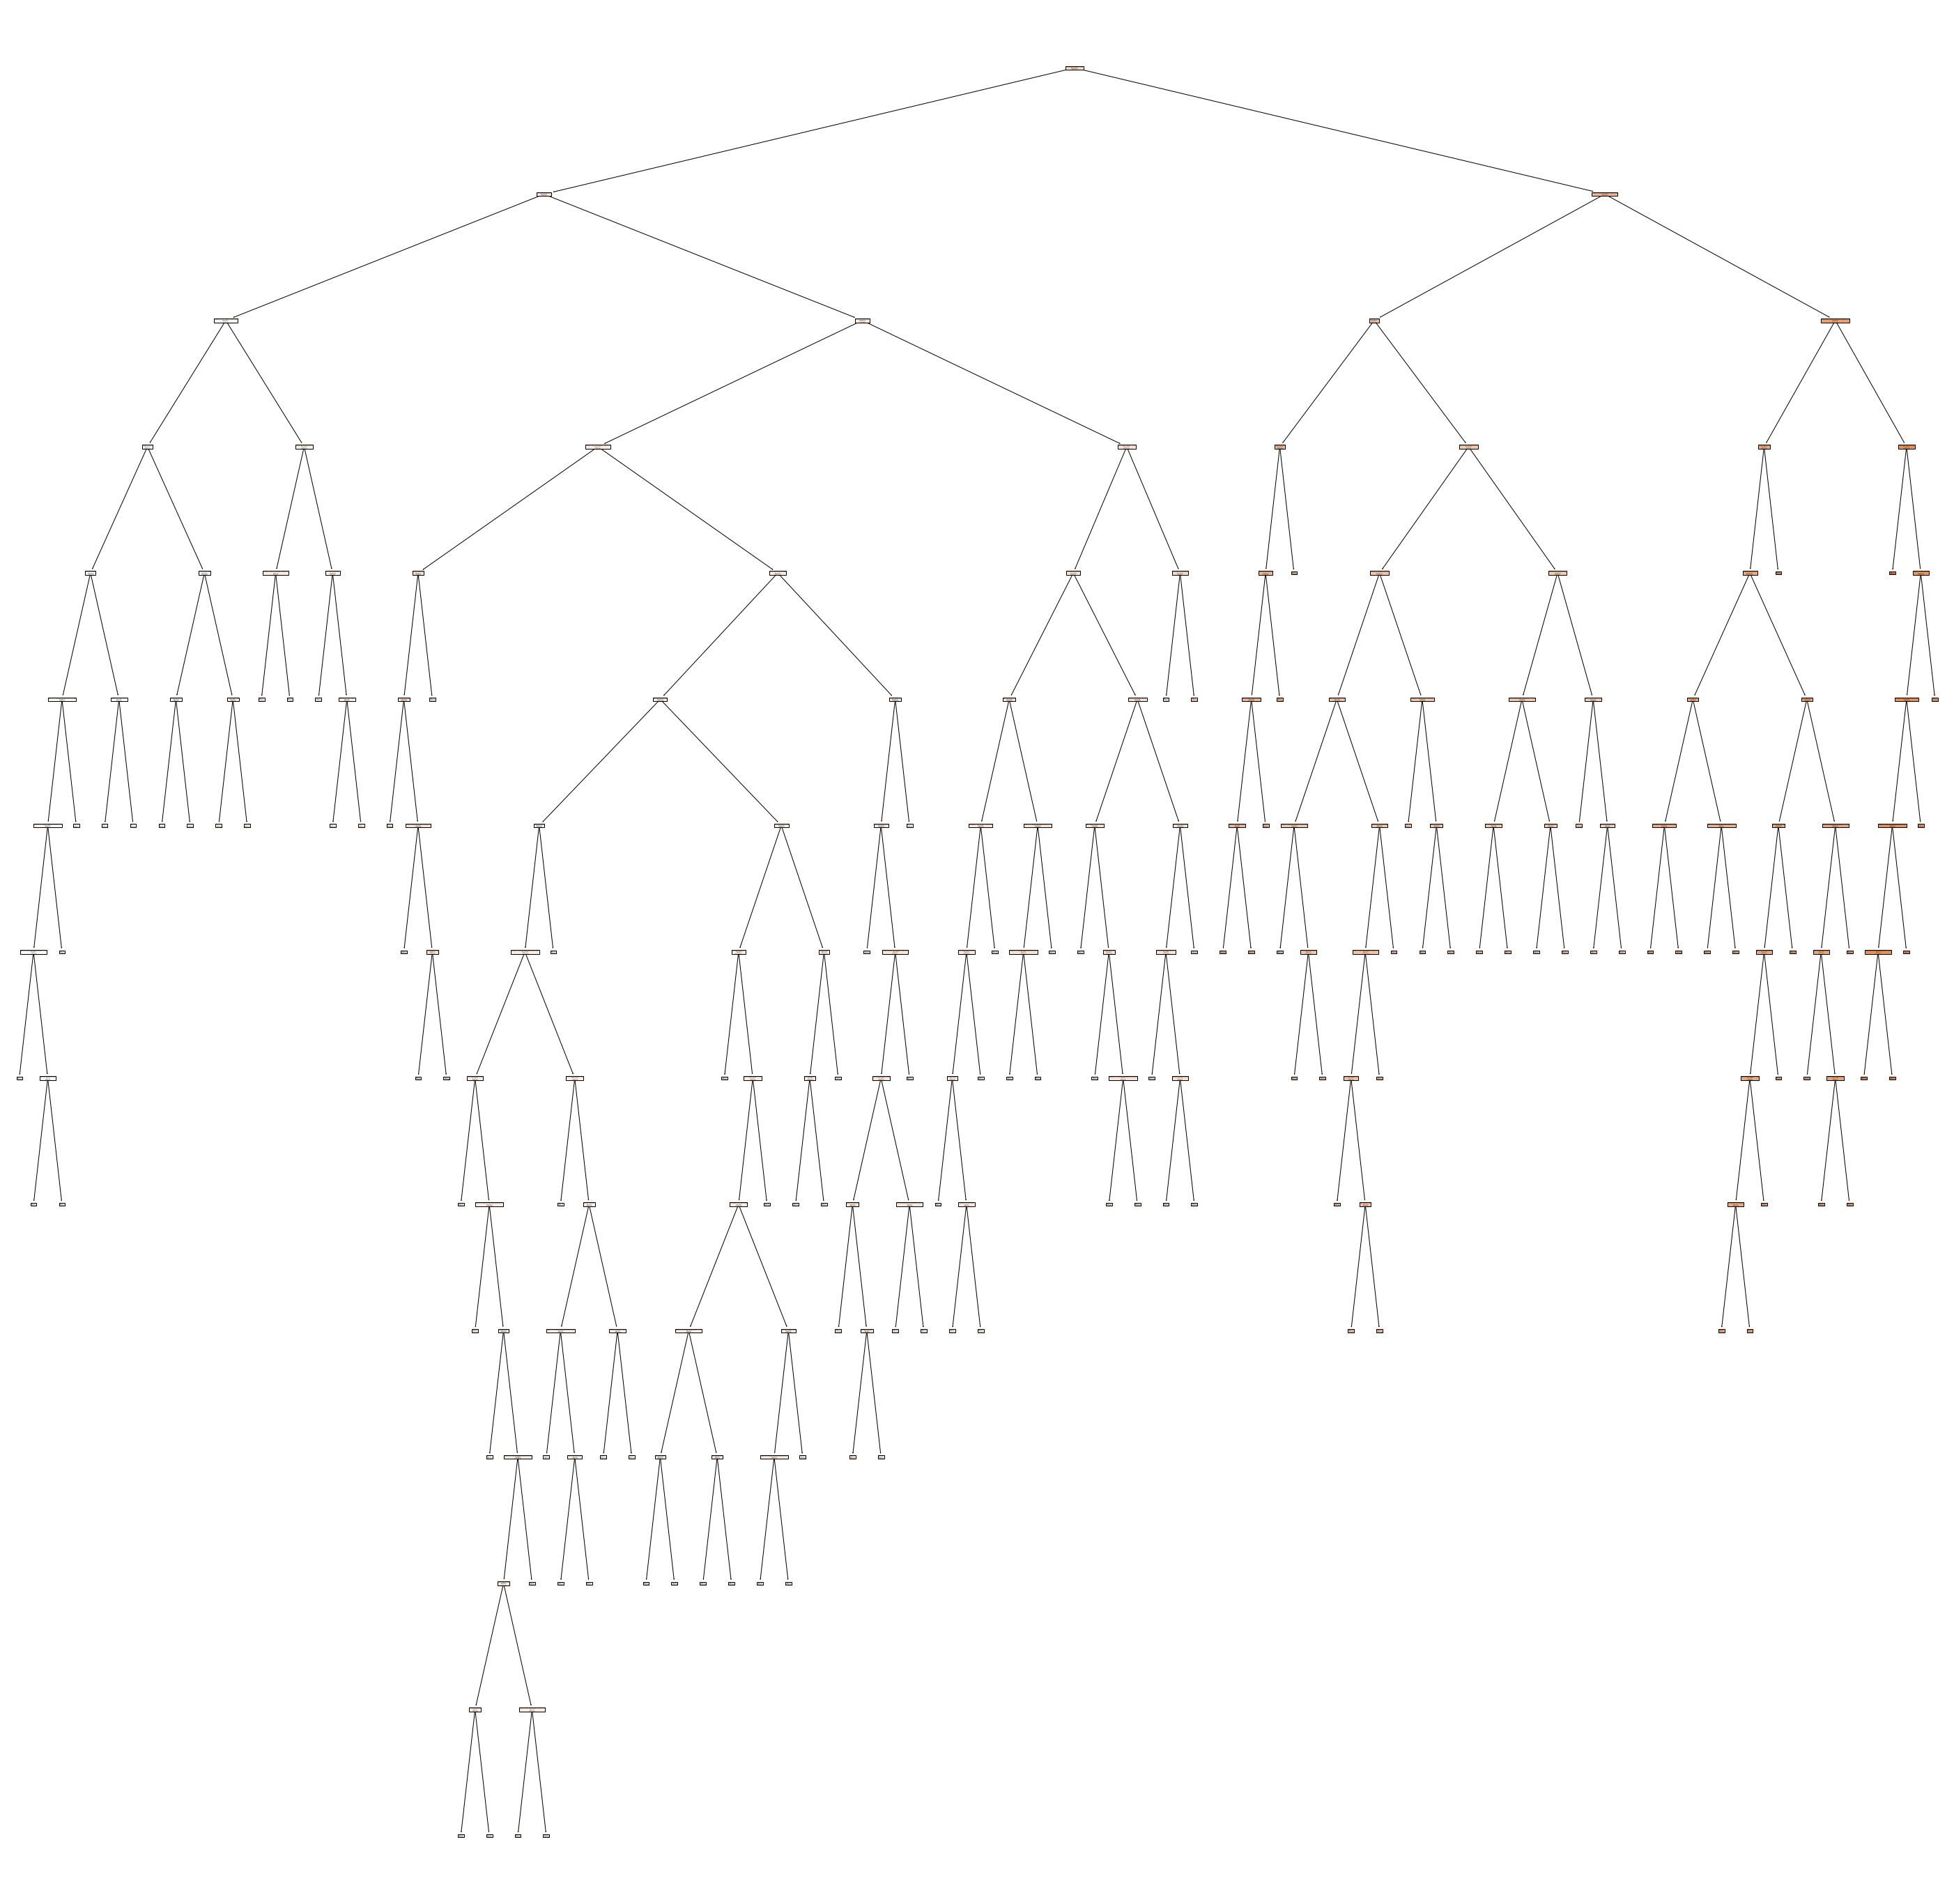

In [28]:
from sklearn import tree

plt.figure(figsize=(50,50))
_ = tree.plot_tree(rf.estimators_[100], feature_names=X.columns, filled=True)